In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, DataCollatorWithPadding
import torch.nn as nn
from transformers import AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F
import warnings
import ast
import random
warnings.filterwarnings('ignore')

/home/pepe/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_dataset(path_to_dataset):
    return pd.read_csv(path_to_dataset, index_col = 0)

def extract_similar_descriptions(e, embeddings, k):
    similarities = cosine_similarity([e], embeddings)[0]
    top_indices = np.argsort(similarities)[-k:][::-1]
    return top_indices
    
def compute_embeddings_distance(embedding_str, k, df):
    #df = load_dataset(path_to_dataset)

    # QUitamos del dataset la misma fila con la que estamos trabajando
    df = df[df["embeddings"]!= embedding_str]

    def parse_embedding(embedding_str):
        embedding_str = embedding_str.strip("[]")
        return np.array(embedding_str.split(), dtype=np.float32)
    
    embedding = parse_embedding(embedding_str)
    df["embeddings"] = df["embeddings"].apply(lambda x: parse_embedding(x))

    df_pos = df[df["label"]==2]
    df_neu = df[df["label"]==1]
    df_neg = df[df["label"]==0]

    pos_description_embeddings = np.vstack(df_pos["embeddings"].values)
    pos_nearest_descriptions = extract_similar_descriptions(embedding, pos_description_embeddings, k)
    pos_result = df_pos.iloc[pos_nearest_descriptions]["post content"]

    neu_description_embeddings = np.vstack(df_neu["embeddings"].values)
    neu_nearest_descriptions = extract_similar_descriptions(embedding, neu_description_embeddings, k)
    neu_result = df_neu.iloc[neu_nearest_descriptions]["post content"]

    neg_description_embeddings = np.vstack(df_neg["embeddings"].values)
    neg_nearest_descriptions = extract_similar_descriptions(embedding, neg_description_embeddings, k)
    neg_result = df_neg.iloc[neg_nearest_descriptions]["post content"]
    

    return pos_result.to_list(), neu_result.to_list(), neg_result.to_list()

mapping = {"NEG":0, "NEU":1, "POS":2}

def label2int(label):
    return mapping[label]

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("Device count:", torch.cuda.device_count())
    print("Current device:", torch.cuda.current_device())
    for i in range(torch.cuda.device_count()):
        print(torch.cuda.get_device_name(i))

Device count: 1
Current device: 0
NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
train_df = load_dataset("../data/train_paraphrased.csv")
test_df = load_dataset("../data/test_paraphrased.csv")
val_df = load_dataset("../data/val_paraphrased.csv")

In [6]:
train_labels = train_df["label"]

In [7]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: tensor([0.9808, 0.6057, 3.0354], device='cuda:0')


In [8]:
class SentimentDataset(Dataset):
    def __init__(self, texts, paraphrases, labels, tokenizer, k, df, type = None, augmentation = False, local_database = train_df):
        super().__init__() 
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.k = k
        self.df = df
        self.local_database = local_database
        self.paraphrases = paraphrases
        self.type = type
        self.augmentation = augmentation

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # DATA AUG
        if self.type == "train" and self.augmentation:
            paraphrase = self.paraphrases[idx]
            samples = ast.literal_eval(paraphrase)
            samples=list(samples)
            samples.append(text)
            text = random.choice(samples)
            index = samples.index(text)


            if index == 0:
                embedding_str = self.df.loc[self.df["paraphrase_esp"] == paraphrase, "embedding_paraphrase_esp1"].values[0]
            elif index == 1:
                embedding_str = self.df.loc[self.df["paraphrase_esp"] == paraphrase, "embedding_paraphrase_esp2"].values[0]
            else: 
                embedding_str = self.df.loc[self.df["post content"] == text, "embeddings"].values[0]

            words = text.split()
            if random.random() < 0.3:
            
                if len(words) > 1:
                    num_to_remove = max(1, int(0.1 * len(words)))  # Quitar ~10% de las palabras
                    indices_to_remove = random.sample(range(len(words)), num_to_remove)
                    words = [w for i, w in enumerate(words) if i not in indices_to_remove]
                    text = " ".join(words)

                if random.random() < 0.3:

                    if len(words) > 1:
                        random.shuffle(words)
                        text = " ".join(words)

        else:
            embedding_str = embedding_str = self.df.loc[self.df["post content"] == text, "embeddings"].values[0]
        
        # Obtener los textos más similares por clase
        pos_texts, neu_texts, neg_texts = compute_embeddings_distance(embedding_str, self.k, self.local_database)
        # Tokenizar el texto principal
        encoding = self.tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

        # Tokenizar los textos más similares
        pos_tokens = self.tokenizer(pos_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        neu_tokens = self.tokenizer(neu_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        neg_tokens = self.tokenizer(neg_texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")
        

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
            "pos_tokens": pos_tokens["input_ids"],
            "neu_tokens": neu_tokens["input_ids"],
            "neg_tokens": neg_tokens["input_ids"],
            "pos_attention": pos_tokens["attention_mask"],
            "neu_attention": neu_tokens["attention_mask"],
            "neg_attention": neg_tokens["attention_mask"],
        }

In [9]:
tokenizer = AutoTokenizer.from_pretrained("pysentimiento/robertuito-sentiment-analysis")

train_dataset = SentimentDataset(
    texts=train_df["post content"].tolist(),
    labels=train_df["label"].tolist(),
    paraphrases=train_df["paraphrase_esp"].tolist(),
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = train_df,
    type = "train",
    augmentation=False
)

val_dataset = SentimentDataset(
    texts=val_df["post content"].tolist(),
    labels=val_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = val_df
)

test_dataset = SentimentDataset(
    texts=test_df["post content"].tolist(),
    labels=test_df["label"].tolist(),
    paraphrases = [],
    tokenizer=tokenizer,
    k=1,  # Número de mensajes similares a recuperar
    df = test_df
)

In [10]:
for i in range(1):
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    print(f"Text: {train_dataset.texts[i]}")
    print(f"Label: {sample['labels'].item()}")
    print(f"Input IDs: {sample['input_ids']}")
    print(f"Attention Mask: {sample['attention_mask']}")
    print(f"Positives: {sample['pos_tokens']}")
    print(f"Neutral: {sample['neu_tokens']}")
    print(f"Negatives: {sample['neg_tokens']}")
    print(f"Positives: {sample['pos_attention']}")
    print(f"Neutral: {sample['neu_attention']}")
    print(f"Negatives: {sample['neg_attention']}")
    print("\n" + "-"*40 + "\n")

Sample 1:
Text: ni idea quin es yo conozco a elon muse que es amigo de donald trans y miler
Label: 1
Input IDs: tensor([    0,   648,  2606,  3554,   442,   560,  4324,   412,   459,   434,
        12125,   443,   442,  1575,   413, 10227,  1531,   445,  1247,   416,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

In [11]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Compute the dot products between Q and K, then scale by the square root of the key dimension
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    # Apply mask if provided (useful for masked self-attention in transformers)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Softmax to normalize scores, producing attention weights
    attention_weights = F.softmax(scores, dim=-1)
    
    # Compute the final output as weighted values
    output = torch.matmul(attention_weights, V)
    return output, attention_weights


class SelfAttention(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.embed_size = embed_size
        # Define linear transformations for Q, K, V
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

    def forward(self, q, k, v, mask=None):
        # Generate Q, K, V matrices
        Q = self.query(q)
        K = self.key(k)
        V = self.value(v)
        
        # Calculate attention using our scaled dot-product function
        out, _ = scaled_dot_product_attention(Q, K, V)
        return out

In [12]:
class SentimentClassifierWithMultiAttention(nn.Module):
    def __init__(self, base_model_name, num_labels=3, num_heads=3):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(base_model_name)

        self.attention_positive = nn.MultiheadAttention(embed_dim=768, num_heads=num_heads, batch_first=True)
        self.attention_negative = nn.MultiheadAttention(embed_dim=768, num_heads=num_heads, batch_first=True)
        self.attention_neutral = nn.MultiheadAttention(embed_dim=768, num_heads=num_heads, batch_first=True)
        """self.attention_positive = SelfAttention(768)
        self.attention_negative = SelfAttention(768)
        self.attention_neutral = SelfAttention(768)"""


        self.linear_intermediate = nn.Linear(768 * 4, 768)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, input_ids, attention_mask, labels=None, pos_tokens=None, neu_tokens=None, neg_tokens=None, pos_attention=None, neu_attention = None, neg_attention = None):
        
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_embedding = outputs.last_hidden_state[:, 0, :]  # Token CLS
        cls_embedding_expanded = cls_embedding.unsqueeze(1)

        pos_outputs_0 = self.bert(pos_tokens[:,0,:], attention_mask=pos_attention[:,0,:])
        pos_cls_embedding_0 = pos_outputs_0.last_hidden_state[:, 0, :]
        pos_cls_embedding_0 = pos_cls_embedding_0.unsqueeze(1)  

        pos_cls_embedding = pos_cls_embedding_0

        neu_outputs_0 = self.bert(neu_tokens[:,0,:], attention_mask=neu_attention[:,0,:])
        neu_cls_embedding_0 = neu_outputs_0.last_hidden_state[:, 0, :]
        neu_cls_embedding_0 = neu_cls_embedding_0.unsqueeze(1)  

        neu_cls_embedding = neu_cls_embedding_0

        neg_outputs_0 = self.bert(neg_tokens[:,0,:], attention_mask=neg_attention[:,0,:])
        neg_cls_embedding_0 = neg_outputs_0.last_hidden_state[:, 0, :]
        neg_cls_embedding_0 = neg_cls_embedding_0.unsqueeze(1)  

        neg_cls_embedding = neg_cls_embedding_0

        cls_embedding_expanded = cls_embedding_expanded.float()
        pos_cls_embedding = pos_cls_embedding.float()
        neg_cls_embedding = neg_cls_embedding.float()
        neu_cls_embedding = neu_cls_embedding.float()

        
        """
        Cada salida (attn_pos, attn_neg, attn_neut) representa una versión contextualizada del cls_embedding 
        influenciada por los mensajes de su respectiva clase. Es decir, el embedding [CLS] de entrada ha sido 
        modificado en función de lo que "aprendió" al atender a los mensajes positivos, negativos o neutros.
        
        """
        
        """attn_pos = self.attention_positive(cls_embedding_expanded, pos_cls_embedding, cls_embedding_expanded)
        attn_neg = self.attention_negative(cls_embedding_expanded, neg_cls_embedding, cls_embedding_expanded)
        attn_neut = self.attention_neutral(cls_embedding_expanded, neu_cls_embedding, cls_embedding_expanded)"""

        attn_pos, _ = self.attention_positive(cls_embedding_expanded, pos_cls_embedding, cls_embedding_expanded)
        attn_neg, _ = self.attention_negative(cls_embedding_expanded, neg_cls_embedding, cls_embedding_expanded)
        attn_neut, _ = self.attention_neutral(cls_embedding_expanded, neu_cls_embedding, cls_embedding_expanded)



        """
        En este punto hemos sacado un nuevo embedding aplicando la capa de atencion del embedding entrante con los dos embeddings de cada clase siendo:
        Q = embedding entrante
        K = clase_emb
        V = embedding entrante

        Porque si V = clase_emb entonces:
        Si pasas clase_emb como V, entonces el mecanismo de atención devolverá una combinación ponderada de los embeddings de la clase POSITIVA, 
        determinada por la similitud entre cls_embedding_expanded (Q) y clase_emb (K).
        """

        combined_embedding = torch.cat([
            cls_embedding,
            attn_pos.squeeze(1),
            attn_neg.squeeze(1),
            attn_neut.squeeze(1)
        ], dim=-1)
        

        logits = self.classifier(self.dropout(self.tanh(self.linear_intermediate(combined_embedding))))
        return logits


MODEL_NAME = "pysentimiento/robertuito-sentiment-analysis"
model = SentimentClassifierWithMultiAttention(MODEL_NAME, num_labels=3)


Some weights of RobertaModel were not initialized from the model checkpoint at pysentimiento/robertuito-sentiment-analysis and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Congelamos todas las capas menos la última capa de clasificación

In [13]:
#for param in list(model.bert.parameters()):
#    param.requires_grad = False

In [14]:
model.to(device)

SentimentClassifierWithMultiAttention(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30002, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
       

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=data_collator)

### Fine-Tuning Context Awareness Model

In [16]:
from torch.optim import AdamW

In [17]:
models_path = "../checkpoints/"

optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

num_epochs = 5
num_training_steps = num_epochs * len(train_dataloader)

print(num_training_steps)

1265


In [18]:
from tqdm.auto import tqdm

train_losses = []
val_losses = []
lfunct = nn.CrossEntropyLoss(weight=class_weights)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0 
    num_train_batches = 0

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)  # Logits
        y_true = batch["labels"]
        
        loss = lfunct(outputs, y_true)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        # Accumulate loss
        epoch_train_loss += loss.item()
        num_train_batches += 1

        progress_bar.update(1)

    # Compute average training loss for the epoch
    avg_train_loss = epoch_train_loss / num_train_batches
    train_losses.append(avg_train_loss)
    
    # Run validation
    model.eval()
    epoch_val_loss = 0
    num_val_batches = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            y_true = batch["labels"]

            loss = lfunct(outputs, y_true)
            epoch_val_loss += loss.item()
            num_val_batches += 1

    avg_val_loss = epoch_val_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save model
    # model.save_pretrained(models_path + f"epoch_{epoch + 1}")


 20%|██        | 253/1265 [23:26<1:13:54,  4.38s/it]

Epoch 1/5 - Train Loss: 0.9950, Val Loss: 0.9903


 40%|████      | 506/1265 [48:37<48:37,  3.84s/it]   

Epoch 2/5 - Train Loss: 0.8278, Val Loss: 1.0296


 60%|██████    | 759/1265 [1:17:02<32:59,  3.91s/it]  

Epoch 3/5 - Train Loss: 0.6310, Val Loss: 1.1815


 80%|████████  | 1012/1265 [1:43:30<17:05,  4.05s/it] 

Epoch 4/5 - Train Loss: 0.4221, Val Loss: 1.5789


100%|██████████| 1265/1265 [2:09:05<00:00,  4.13s/it]  

Epoch 5/5 - Train Loss: 0.2629, Val Loss: 1.7765


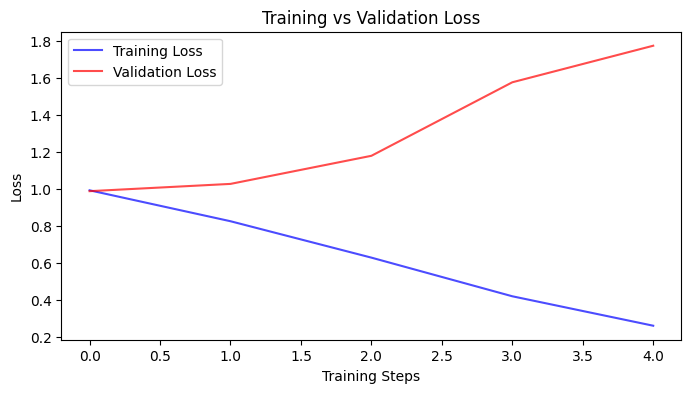

In [19]:
import matplotlib.pyplot as plt
# Plot Training vs Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Training Loss", color="blue", alpha=0.7)
plt.plot(val_losses, label="Validation Loss", color="red", alpha=0.7)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [20]:
#torch.save(model.state_dict(), "../checkpoints/context.pth")

In [21]:
#torch.save(model, "../checkpoints/full_context_model.pth")

In [22]:
from sklearn.metrics import classification_report

model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in val_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)
print(classification_report(y_true_val, y_pred_val, target_names=mapping.keys()))

(577,) (577,)
              precision    recall  f1-score   support

         NEG       0.57      0.59      0.58       196
         NEU       0.70      0.67      0.69       318
         POS       0.31      0.35      0.33        63

    accuracy                           0.61       577
   macro avg       0.53      0.54      0.53       577
weighted avg       0.62      0.61      0.61       577



In [23]:
from sklearn.metrics import classification_report

model.eval()

y_pred_val = []
y_true_val = []
with torch.no_grad(): 
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        y_pred_val.extend(torch.argmax(outputs, dim=-1).tolist())
        y_true_val.extend(batch["labels"].tolist())

y_pred_val = np.array(y_pred_val)
y_true_val = np.array(y_true_val)
print(y_pred_val.shape, y_true_val.shape)
print(classification_report(y_true_val, y_pred_val, target_names=mapping.keys()))

(1153,) (1153,)
              precision    recall  f1-score   support

         NEG       0.56      0.59      0.57       392
         NEU       0.69      0.64      0.66       634
         POS       0.32      0.37      0.35       127

    accuracy                           0.59      1153
   macro avg       0.52      0.53      0.53      1153
weighted avg       0.60      0.59      0.60      1153

